<a href="https://colab.research.google.com/github/sinajamshidi247/scientific--project/blob/master/matbench_expt_is_metal/expt_is_metal_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet 'matbench_expt_is_metal' benchmarking

Matbench v0.1 test dataset for classifying metallicity from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, ensuring no conflicting reports were entered for any compositions (i.e., no reported compositions were both metal and nonmetal). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	is_metal: Target variable. 1 if is a metal, 0 if nonmetal.
Num Entries: 4921
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673
 https//:doi.org/10.1021/acs.jpclett.8b00124.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plts
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
!pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.8 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=81a801fb371dabbea73727c04d8e422035f015fdfd7998a67d0dcef121336ac2
  Store

In [3]:
!pip -q install "numpy==1.26.4"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
access 1.1.10.post3 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
inequality 1.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
mapclassify 2.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
sha

In [2]:
!pip install modnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of modnet to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 13.5 

In [12]:
import pandas as pd
from pymatgen.core import Composition
from modnet.featurizers.presets import CompositionOnlyFeaturizer

f = CompositionOnlyFeaturizer()

df_test = pd.DataFrame({"composition": [Composition("Fe2O3"), Composition("SiO2")]})
df_feat = f.featurize_composition(df_test)

print("Num features:", df_feat.shape[1])
print(df_feat.columns[:30])   # feature names


/usr/local/lib/python3.12/dist-packages/modnet/featurizers/presets/debreuck_2020.py:41: UserWarning: The CompositionOnlyFeaturizer preset was written for and tested only with matminer==0.6.2.
Newer versions of matminer will not work, and older versions may not be compatible with newer MODNet versions due to other conflicts.
To use this featurizer robustly, please install `modnet==0.1.13` with its pinned dependencies.

This preset will now be initialised without importing matminer featurizers to enable use with existing previously featurized data, but attempts to perform further featurization will result in an error.
  warnings.warn(


KeyError: 'AtomicOrbitals|HOMO_character'

In [ ]:
import modnet
modnet.__version__

'0.4.1'

In [ ]:
Markdown(filename="./README.md")

## Data exploration

In [2]:
df = load_dataset("matbench_expt_is_metal")
df["composition"] = df["composition"].map(Composition)

In [3]:
df.columns

Index(['composition', 'is_metal'], dtype='object')

In [4]:
df.head(10)

,composition,is_metal
0,"(Ag, Au, S)",True
1,"(Ag, W, Br)",True
2,"(Ag, Ge, Pb, S)",False
3,"(Ag, Ge, Pb, Se)",False
4,"(Ag, B, Br)",True
5,"(Ag, Bi, O)",True
6,"(Ag, Ge, S)",False
7,"(Ag, Ge, Se)",False
8,"(Ag, Ge, Te)",False
9,"(Ag, Hg, I)",False


In [ ]:
len(df)

4921

### Composition space

In [11]:
## /!\ the interpretation is different from the steels
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    tot = np.sum(list(s.values()))
    for e in s:
        elements[e] += 1
        proportions[e] += [s[e]/tot]

for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True)) #compute average composition fraction per element
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w",figsize=(22,7));
#ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel(" compound fraction containing element e");

AttributeError: module 'matplotlib' has no attribute 'subplots'

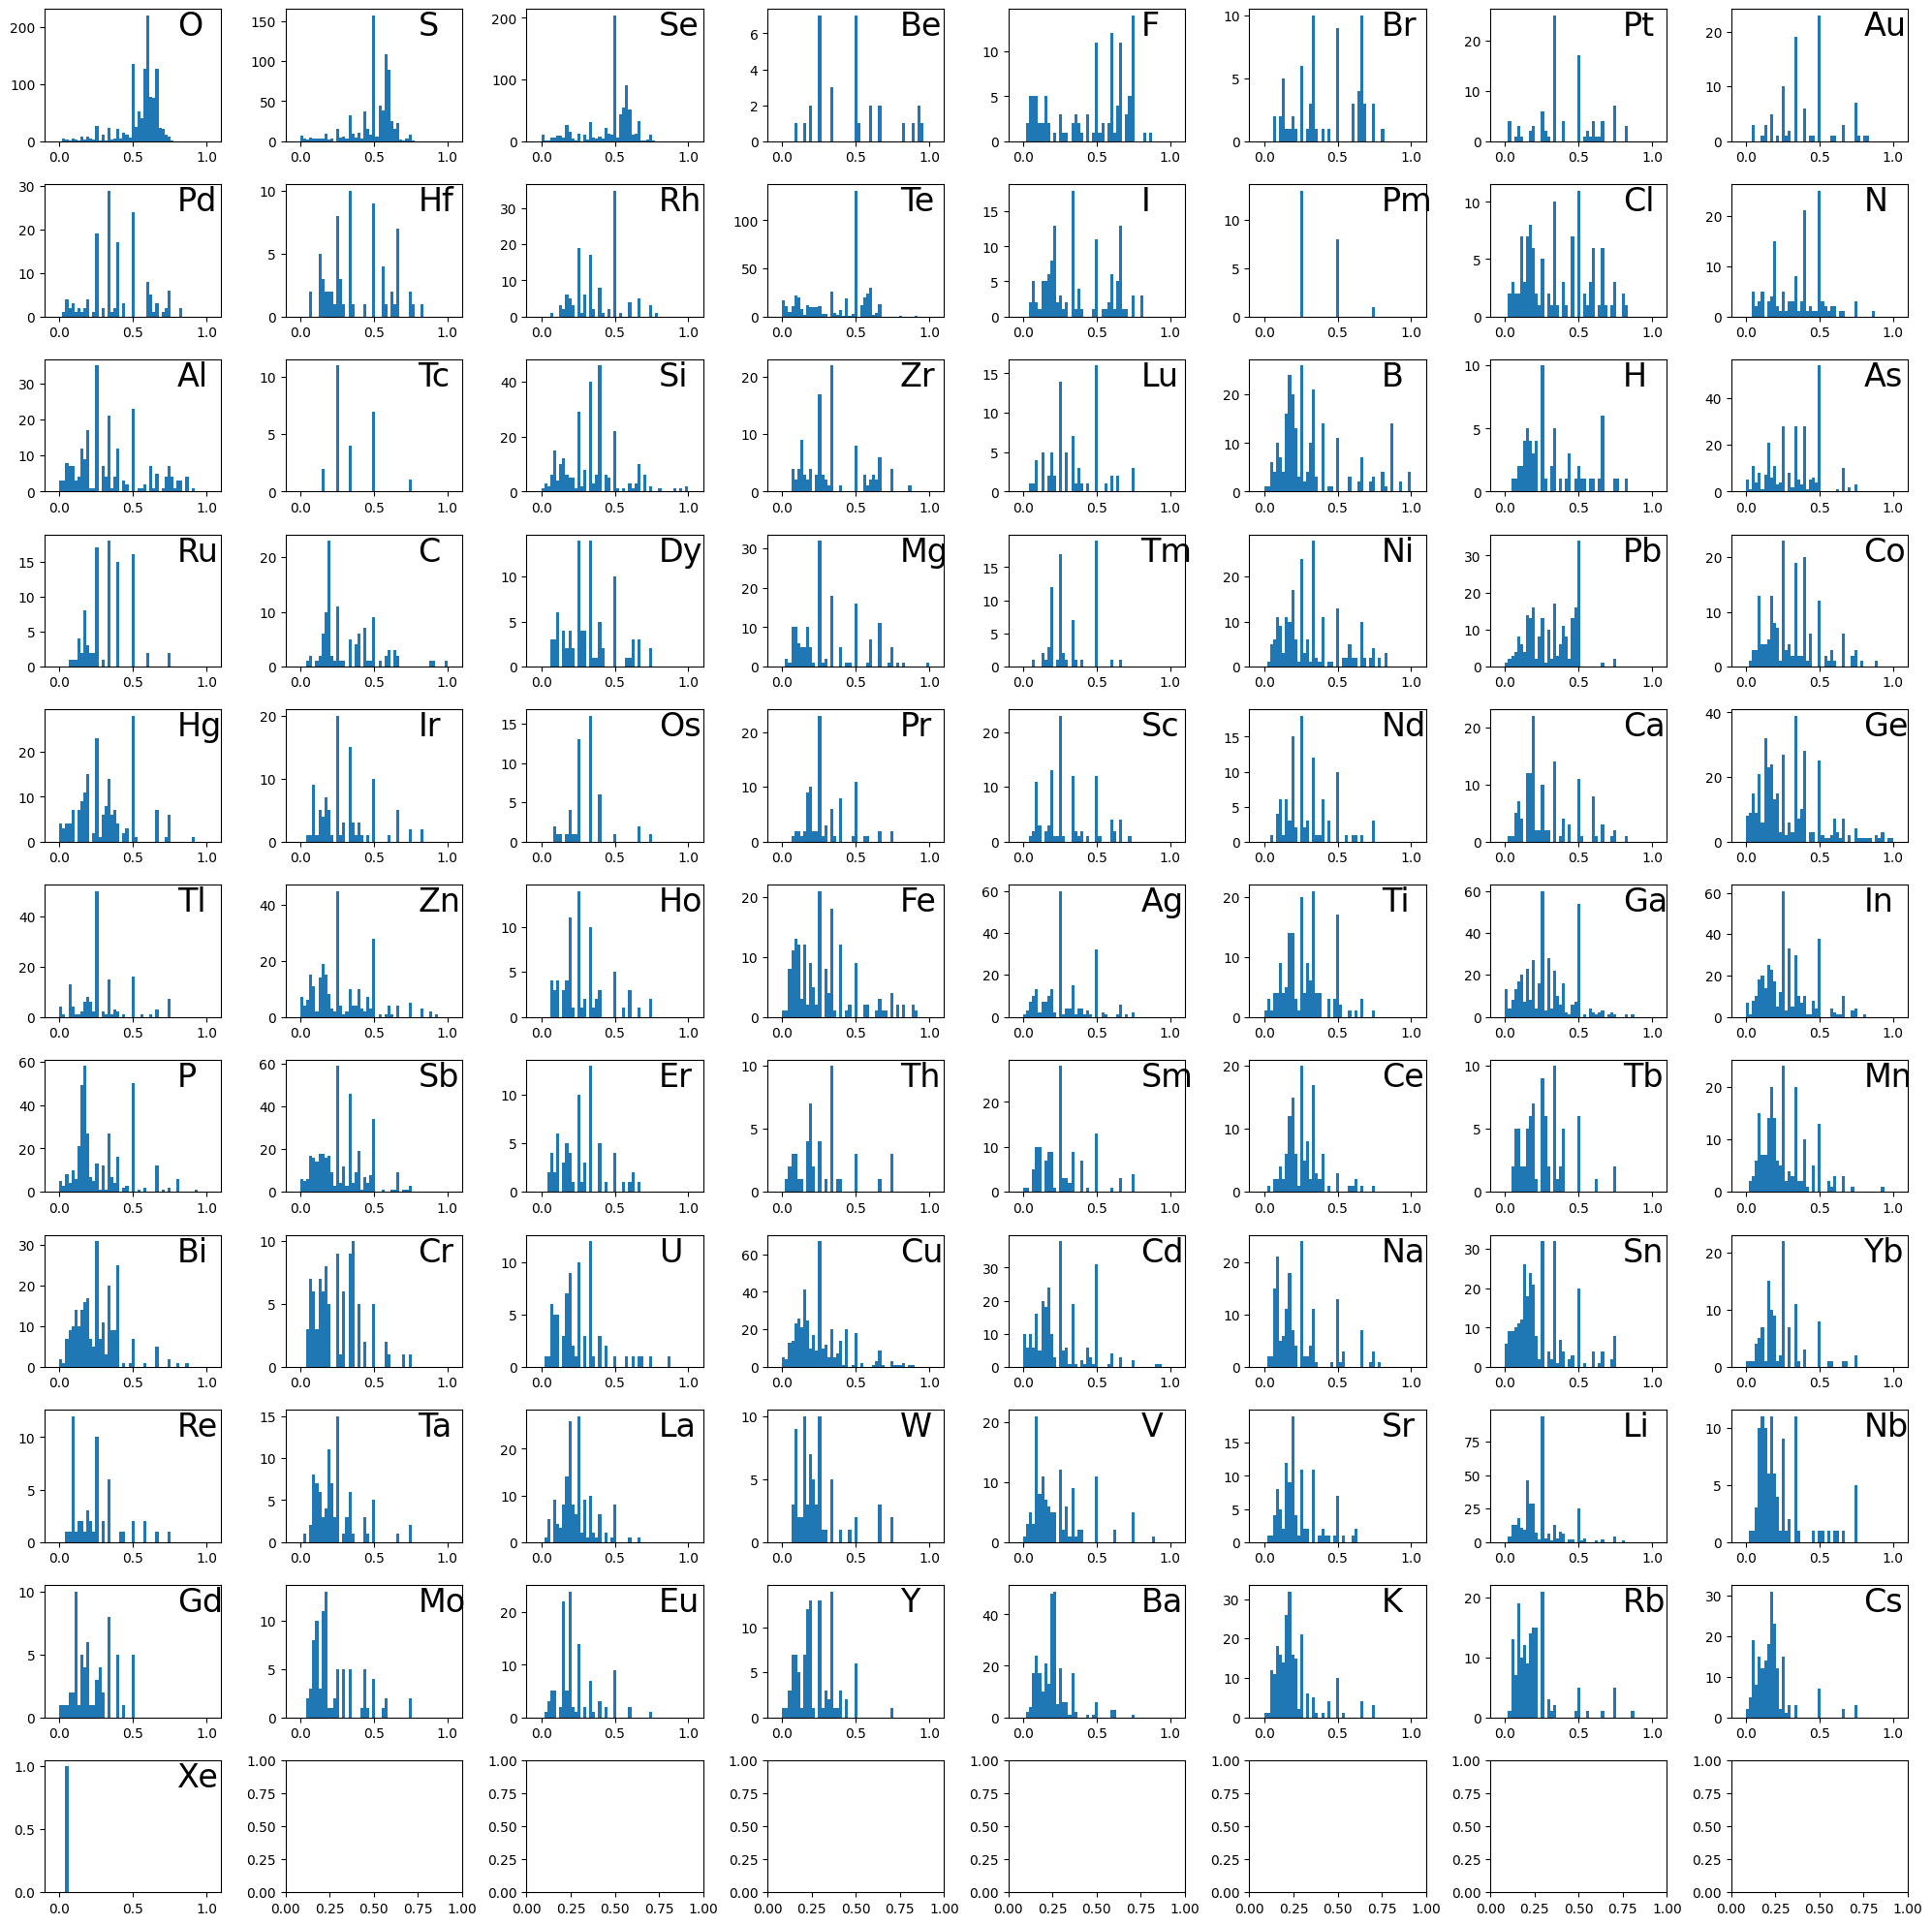

In [ ]:
# distribution of element proportions across compositions
fig, axis = plt.subplots(11, 8, facecolor="w", figsize=(20, 20))
for ax, elem in zip(axis.flatten(), mean_proportions):
    ax.hist(
        proportions[elem],
        bins=np.linspace(0, 1, 50),
        density=False,
    )
    ax.set_xlim(-0.1, 1.1)
    ax.text(0.75, 0.8, elem, fontsize=24, transform=ax.transAxes, )
    #ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [ ]:
df['is_metal'] = df['is_metal'].map(int)
df.describe()

,is_metal
count,4921.000000
mean,0.498069
std,0.500047
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["is_metal"]);
ax.set_ylabel("Frequency")
ax.set_xlabel("is metal")

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [ ]:
df = load_dataset("matbench_expt_is_metal").iloc[:335].copy()
df["composition"] = df["composition"].map(Composition)

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [4]:
import numpy as np
from pymatgen.core.periodic_table import Element

from modnet.featurizers import MODFeaturizer, clean_df
from modnet.featurizers.presets.debreuck_2020 import CompositionOnlyFeaturizer as DeBreuckCompositionOnlyFeaturizer

class NoOxidDeBreuckFeaturizer(MODFeaturizer):
    def __init__(self, n_jobs=1):
        super().__init__(n_jobs=n_jobs)

        preset = DeBreuckCompositionOnlyFeaturizer()
        if hasattr(preset, "load_featurizers"):
            preset.load_featurizers()

        # Copy featurizers, but remove anything oxidation-related (robust filter)
        raw = preset.composition_featurizers or []
        kept = []
        for item in raw:
            if isinstance(item, tuple) and len(item) == 2:
                name, obj = item
                tag = (str(name) + " " + type(obj).__name__).lower()
                if "oxid" not in tag:
                    kept.append(obj)
            else:
                tag = (type(item).__name__ + " " + repr(item)).lower()
                if "oxid" not in tag:
                    kept.append(item)

        self.composition_featurizers = kept
        self.structure_featurizers = []

    def featurize_composition(self, df):
        # IMPORTANT: call the base class to avoid any preset override logic
        df = MODFeaturizer.featurize_composition(self, df)

        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        if "AtomicOrbitals|HOMO_character" in df.columns:
            df["AtomicOrbitals|HOMO_character"] = df["AtomicOrbitals|HOMO_character"].map(_orbitals)
        if "AtomicOrbitals|LUMO_character" in df.columns:
            df["AtomicOrbitals|LUMO_character"] = df["AtomicOrbitals|LUMO_character"].map(_orbitals)

        if "AtomicOrbitals|HOMO_element" in df.columns:
            df["AtomicOrbitals|HOMO_element"] = df["AtomicOrbitals|HOMO_element"].apply(
                lambda x: -1 if not isinstance(x, str) else Element(x).Z
            )
        if "AtomicOrbitals|LUMO_element" in df.columns:
            df["AtomicOrbitals|LUMO_element"] = df["AtomicOrbitals|LUMO_element"].apply(
                lambda x: -1 if not isinstance(x, str) else Element(x).Z
            )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        return clean_df(df)

In [6]:
# build featurizer
feat = CompositionOnlyFeaturizer(n_jobs=1)

# remove the slow oxidation-state step
feat.composition_featurizers = [
    f for f in feat.composition_featurizers
    if f.__class__.__name__ != "CompositionToOxidComposition"
]

print("Featurizers kept:", [f.__class__.__name__ for f in feat.composition_featurizers])


/usr/local/lib/python3.12/dist-packages/modnet/featurizers/presets/debreuck_2020.py:41: UserWarning: The CompositionOnlyFeaturizer preset was written for and tested only with matminer==0.6.2.
Newer versions of matminer will not work, and older versions may not be compatible with newer MODNet versions due to other conflicts.
To use this featurizer robustly, please install `modnet==0.1.13` with its pinned dependencies.

This preset will now be initialised without importing matminer featurizers to enable use with existing previously featurized data, but attempts to perform further featurization will result in an error.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/matminer/featurizers/composition/packing.py:84: UserWarning: AtomicPackingEfficiency(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the

Featurizers kept: ['AtomicOrbitals', 'AtomicPackingEfficiency', 'BandCenter', 'ElementFraction', 'ElementProperty', 'IonProperty', 'Miedema', 'Stoichiometry', 'TMetalFraction', 'ValenceOrbital', 'YangSolidSolution']


/usr/local/lib/python3.12/dist-packages/matminer/featurizers/site/chemical.py:335: UserWarning: LocalPropertyDifference(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [5]:
feat = NoOxidDeBreuckFeaturizer(n_jobs=1)

data = MODData(
    structures=df["composition"].tolist(),
    targets=df["is_metal"].tolist(),
    target_names=["is_metal"],
    featurizer=feat,
    num_classes={"is_metal": 2},
)

data.featurize()
print("df_featurized:", data.df_featurized.shape)


/usr/local/lib/python3.12/dist-packages/modnet/featurizers/presets/debreuck_2020.py:41: UserWarning: The CompositionOnlyFeaturizer preset was written for and tested only with matminer==0.6.2.
Newer versions of matminer will not work, and older versions may not be compatible with newer MODNet versions due to other conflicts.
To use this featurizer robustly, please install `modnet==0.1.13` with its pinned dependencies.

This preset will now be initialised without importing matminer featurizers to enable use with existing previously featurized data, but attempts to perform further featurization will result in an error.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/matminer/featurizers/composition/packing.py:84: UserWarning: AtomicPackingEfficiency(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the

2026-01-02 22:38:25,638 - modnet - INFO - Loaded NoOxidDeBreuckFeaturizer featurizer.


INFO:modnet:Loaded NoOxidDeBreuckFeaturizer featurizer.


2026-01-02 22:38:25,691 - modnet - INFO - Computing features, this can take time...


INFO:modnet:Computing features, this can take time...


2026-01-02 22:38:25,704 - modnet - INFO - Applying composition featurizers...


INFO:modnet:Applying composition featurizers...


2026-01-02 22:38:25,724 - modnet - INFO - Applying featurizers [AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7b49d846a900>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(data_source=<matminer.utils.data.PymatgenData object at 0x7b49d8594c80>), Miedema(ss_types=['min'], struct_types=['inter', 'amor', 'ss']), Stoichiometry(), TMetalFr

INFO:modnet:Applying featurizers [AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7b49d846a900>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(data_source=<matminer.utils.data.PymatgenData object at 0x7b49d8594c80>), Miedema(ss_types=['min'], struct_types=['inter', 'amor', 'ss']), Stoichiometry(), TMetalFraction(), ValenceOrbital(), Ya

MultipleFeaturizer:   0%|          | 0/4921 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:380: UserWarning: PymatgenData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:380: UserWarning: PymatgenData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the 

2026-01-02 23:06:49,372 - modnet - INFO - Data has successfully been featurized!


INFO:modnet:Data has successfully been featurized!


df_featurized: (4921, 285)


In [6]:
data.feature_selection(n=-1)          # rank all
ranked = data.optimal_features
with open("features_ranked.txt","w") as f:
    f.write("\n".join(ranked))

2026-01-02 23:39:33,425 - modnet - INFO - Multiprocessing on 1 workers.


INFO:modnet:Multiprocessing on 1 workers.


2026-01-02 23:39:33,433 - modnet - INFO - Computing "self" MI (i.e. information entropy) of features


INFO:modnet:Computing "self" MI (i.e. information entropy) of features
100%|██████████| 285/285 [00:15<00:00, 18.73it/s]

2026-01-02 23:39:48,714 - modnet - INFO - Computing cross NMI between all features...



INFO:modnet:Computing cross NMI between all features...
100%|██████████| 19110/19110 [11:51<00:00, 26.88it/s]

2026-01-02 23:51:39,959 - modnet - INFO - Starting target 1/1: is_metal ...



INFO:modnet:Starting target 1/1: is_metal ...


2026-01-02 23:51:39,963 - modnet - INFO - Computing mutual information between features and target...


INFO:modnet:Computing mutual information between features and target...


2026-01-02 23:51:55,297 - modnet - INFO - Computing optimal features...


INFO:modnet:Computing optimal features...


2026-01-02 23:51:59,271 - modnet - INFO - Selected 50/192 features...


INFO:modnet:Selected 50/192 features...


2026-01-02 23:52:03,315 - modnet - INFO - Selected 100/192 features...


INFO:modnet:Selected 100/192 features...


2026-01-02 23:52:05,311 - modnet - INFO - Selected 150/192 features...


INFO:modnet:Selected 150/192 features...


2026-01-02 23:52:05,960 - modnet - INFO - Done with target 1/1: is_metal.


INFO:modnet:Done with target 1/1: is_metal.


2026-01-02 23:52:05,961 - modnet - INFO - Merging all features...


INFO:modnet:Merging all features...


2026-01-02 23:52:05,966 - modnet - INFO - Done.


INFO:modnet:Done.


In [15]:
len(ranked)

192

In [ ]:
print("X shape:", data.df_featurized.shape)

feat_names = data.df_featurized.columns.tolist()
print("n_features:", len(feat_names))
print("first 50 features:\n", feat_names[:50])

# save them
with open("expt_is_metal_all_features.txt", "w") as f:
    f.write("\n".join(feat_names))


In [ ]:
import os, shutil

PRECOMPUTED_MODDATA = "./precomputed/expt_is_metal_benchmark_moddata.pkl.gz"

# 1) Remove broken cached file if it exists
if os.path.isfile(PRECOMPUTED_MODDATA):
    os.remove(PRECOMPUTED_MODDATA)
    print("Deleted cached MODData:", PRECOMPUTED_MODDATA)

# 2) Also remove the folder if it exists and you want a fully clean start (optional)
# shutil.rmtree("./precomputed", ignore_errors=True)


In [ ]:
PRECOMPUTED_MODDATA = "./precomputed/expt_is_metal_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
    print("we are here !")
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_expt_is_metal")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)

    data = MODData(
        structures=df["structure"].tolist(),
        targets=df["is_metal"].tolist(),
        target_names=["is_metal"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8),
        num_classes = {'is_metal':2}
    )
    data.featurize()
    # As this is a small data/feature set, order all features
    data.feature_selection(n=-1)


2026-01-01 20:18:52,867 - modnet - INFO - Loaded CompositionOnlyFeaturizer featurizer.


INFO:modnet:Loaded CompositionOnlyFeaturizer featurizer.


2026-01-01 20:18:52,894 - modnet - INFO - Computing features, this can take time...


INFO:modnet:Computing features, this can take time...


2026-01-01 20:18:52,907 - modnet - INFO - Data has successfully been featurized!


INFO:modnet:Data has successfully been featurized!


2026-01-01 20:18:52,945 - modnet - INFO - Multiprocessing on 1 workers.


INFO:modnet:Multiprocessing on 1 workers.


2026-01-01 20:18:52,949 - modnet - INFO - Computing "self" MI (i.e. information entropy) of features


INFO:modnet:Computing "self" MI (i.e. information entropy) of features
0it [00:00, ?it/s]

2026-01-01 20:18:52,968 - modnet - INFO - Computing cross NMI between all features...



INFO:modnet:Computing cross NMI between all features...
0it [00:00, ?it/s]

2026-01-01 20:18:53,010 - modnet - INFO - Starting target 1/1: is_metal ...



INFO:modnet:Starting target 1/1: is_metal ...


2026-01-01 20:18:53,012 - modnet - INFO - Computing mutual information between features and target...


INFO:modnet:Computing mutual information between features and target...


ValueError: The input features DataFrame and the target variable DataFrame should contain the same number of data points.

In [ ]:
print("n structures:", len(data.df_structure))
print(data.df_structure.head())

s0 = data.df_structure.iloc[0]["structure"]
print("structure type:", type(s0))
print("has composition:", hasattr(s0, "composition"))
print("composition:", s0.composition)

# try featurizing a tiny subset to catch the real error
tiny = data.df_structure.iloc[:5].copy()
Xtiny = data.featurizer.featurize(tiny)
print("Xtiny:", Xtiny.shape)
print("cols:", Xtiny.columns[:20])


n structures: 4921
                                             structure
id                                                    
id0  <__main__.CompositionContainer object at 0x7ef...
id1  <__main__.CompositionContainer object at 0x7ef...
id2  <__main__.CompositionContainer object at 0x7ef...
id3  <__main__.CompositionContainer object at 0x7ef...
id4  <__main__.CompositionContainer object at 0x7ef...
structure type: <class '__main__.CompositionContainer'>
has composition: True
composition: Ag1 Au2 S2
Xtiny: (0, 0)
cols: Index([], dtype='object')


In [ ]:
from modnet.featurizers.presets import DeBreuck2020Featurizer

print("type:", type(DeBreuck2020Featurizer.composition_featurizers))
try:
    print("len:", len(DeBreuck2020Featurizer.composition_featurizers))
except Exception as e:
    print("len() failed:", e)


type: <class 'NoneType'>
len() failed: object of type 'NoneType' has no len()


In [ ]:
print(len(data.df_featurized.columns))
print(list(data.df_featurized.columns)[:30])


0
[]


In [ ]:
data.df_featurized.shape


(0, 0)

In [ ]:
print("Has df_featurized attr?", hasattr(data, "df_featurized"))
print("Has df_targets attr?  ", hasattr(data, "df_targets"))

df_feat = getattr(data, "df_featurized", None)
df_targ = getattr(data, "df_targets", None)

print("df_featurized is None?", df_feat is None)
print("df_targets is None?   ", df_targ is None)
print("df_featurized type:", type(df_feat))
print("df_targets type:   ", type(df_targ))

Has df_featurized attr? True
Has df_targets attr?   True
df_featurized is None? False
df_targets is None?    False
df_featurized type: <class 'pandas.core.frame.DataFrame'>
df_targets type:    <class 'pandas.core.frame.DataFrame'>


In [ ]:
data.featurize()

2025-12-15 19:11:14,279 - modnet - INFO - Computing features, this can take time...


INFO:modnet:Computing features, this can take time...


RuntimeError: Not overwriting existing featurized dataframe.

In [ ]:
print("df_featurized:", data.df_featurized.shape)


df_featurized: (0, 0)


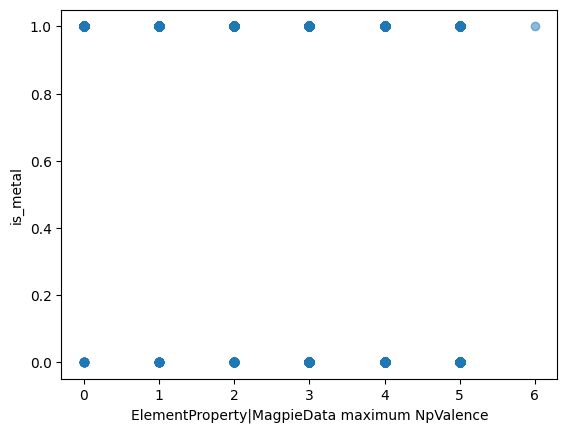

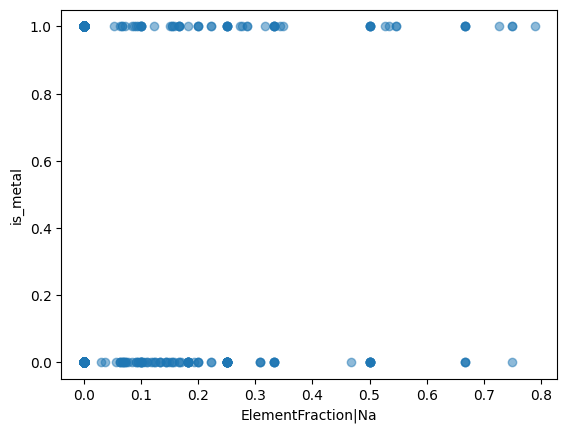

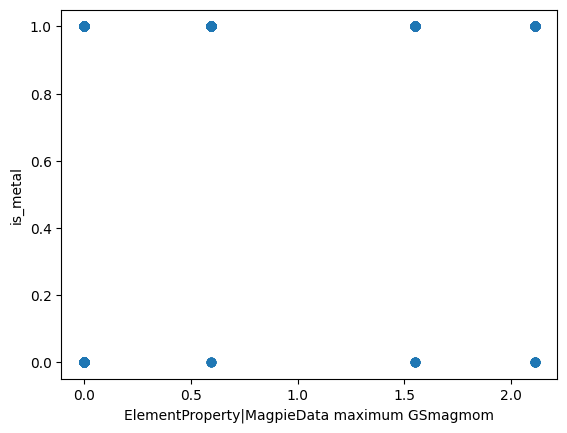

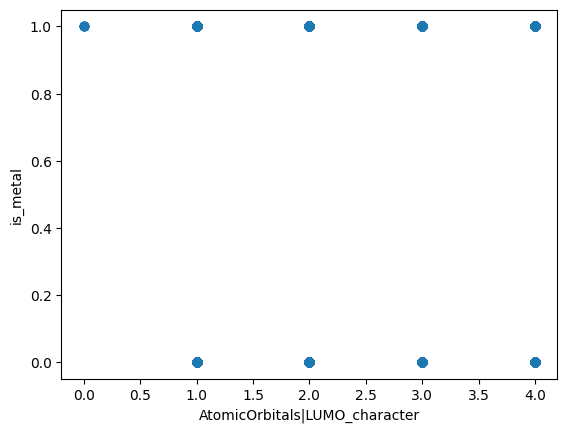

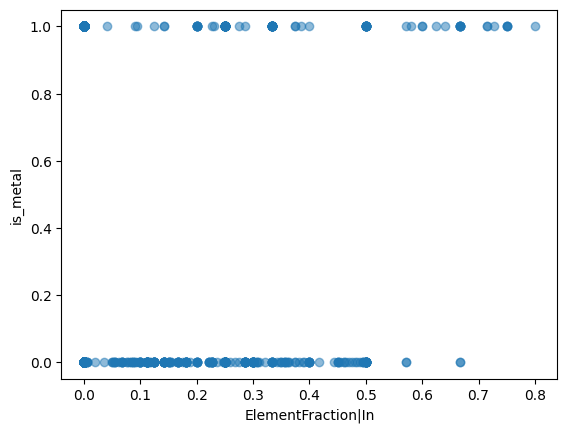

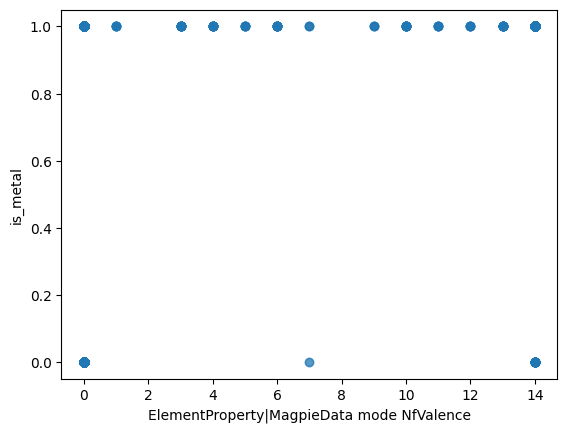

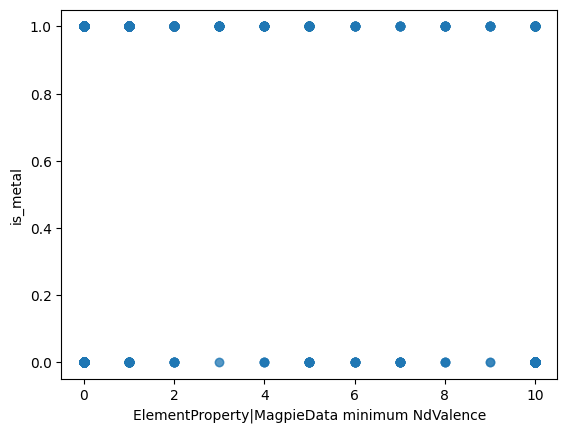

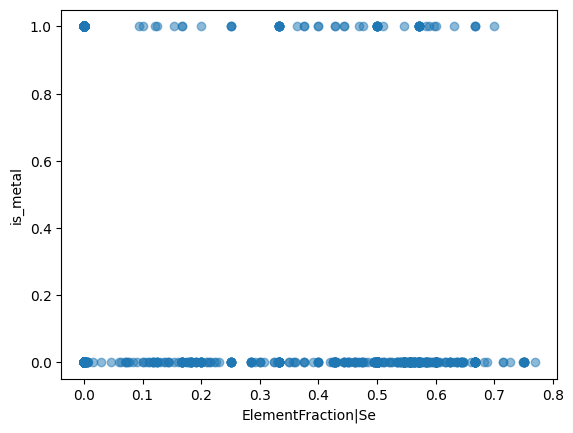

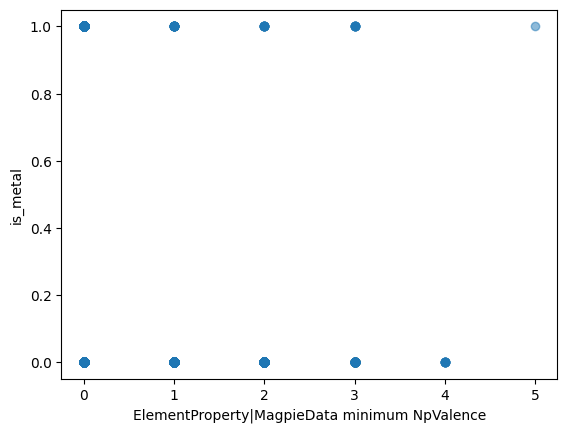

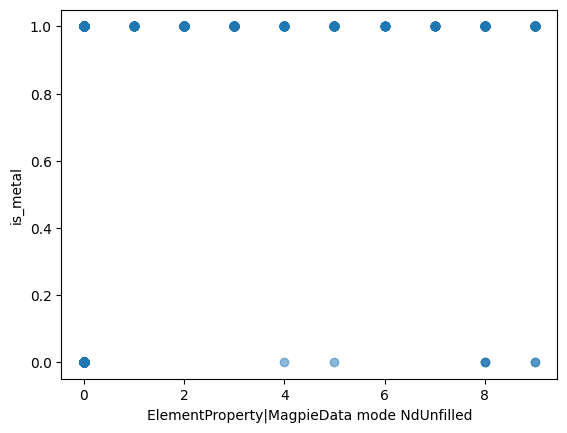

In [14]:
# Look at some of the top features chosen by MODNet
import matplotlib.pyplot as plt

for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("is_metal")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [16]:
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *

ModuleNotFoundError: No module named 'modnet_matbench'

In [17]:
from sklearn.model_selection import KFold
#from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets['is_metal'] = data.df_targets['is_metal'].map(int)

best_settings = {
    "increase_bs":False,
    "num_neurons": [[128], [32], [32], [16]],
    "n_feat": 120,
    "lr": 0.005, #0.005
    "epochs": 100,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "num_classes": {'is_metal':2},
    "loss": "categorical_crossentropy",
    #"xscale": "standard",
}

results = matbench_benchmark(data, [[["is_metal"]]], {"is_metal": 1}, best_settings,classification=True, save_folds=True)
np.mean(results['scores'])

NameError: name 'matbench_benchmark' is not defined

In [ ]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    #plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

## Feature selection

In [ ]:
model = results['models'][0]

In [ ]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [ ]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [ ]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

In [ ]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    feature_names=model.optimal_descriptors[:model.n_feat],
    out_names=["is_not_metal"],
)

In [ ]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])